In [1]:
from imblearn.over_sampling import RandomOverSampler
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.models import load_model
from keras.models import Sequential
from keras.utils import to_categorical
from skimage.transform import resize
from skimage import segmentation
from skimage.morphology import watershed
from skimage import measure
from skimage import morphology
from sklearn.model_selection import train_test_split
import csv
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


## Set global variables and model hyper-parameters

In [8]:
# set global variables and hyper-parameters
DATA_LOCATION = '../data/'
TRAIN_IMAGES_LOCATION = '../data/train_images/'
IMAGE_SIZE = 48
N_CLASSES = 121
BATCH_SIZE = 32
N_EPOCHS = 15

# load train images filenames with class labels
filenames = [i for i in os.listdir('../data/train_images') if i.endswith('.jpg')]
with open(DATA_LOCATION + 'train_onelabel.csv', mode='r') as infile:
    reader = csv.reader(infile)
    file_to_class = {rows[0]:rows[1] for rows in reader}

# calculate new class counts, converging towards max (1580)
with open(DATA_LOCATION + 'train_onelabel.csv', mode='r') as infile:
    reader = csv.reader(infile)
    class_counts = {}
    for row in reader:
        if(row[1] != 'class'):
            class_counts[int(row[1])] = class_counts.get(int(row[1]), 0) + 1
    max_nr = max(class_counts.values())
    for key, value in class_counts.items():
        class_counts[key] = int(class_counts[key] + (max_nr - class_counts[key])/6)

X = np.empty([len(filenames),IMAGE_SIZE,IMAGE_SIZE,1])
Y_tmp = np.empty([len(filenames)])
Y = np.empty([sum(class_counts.values()),N_CLASSES])
print('Shapes:\nX:{}\nY:{}'.format(X.shape, Y.shape))

Shapes:
X:(24204, 48, 48, 1)
Y:(51985, 121)


In [3]:
def get_padding(i):
    """
    Helper function for getting right padding sizes
    input:
        - i: positive integer gotten from substracting height and width of an image
    output:
        - Tuple representing the correct padding
    """
    if i%2 == 0:
        return (int(i/2),int(i/2))
    else:
        return (int(i/2-.5), int(i/2+.5))

def pad_image(img):
    """
    Add padding to image to make it square
    input:
        - img: numpy array (2D) representing image
    output:
        - padded array of shape (N,N)
    """
    H, W = img.shape
    if H == W:
        return img
    elif H > W:
        return np.pad(img, ((0,0), get_padding(H-W)), 'constant')
    else:
        return np.pad(img, (get_padding(W-H), (0,0)), 'constant')

def resize_image(img):
    """
    Resize image to new square shape
    input:
        - img: numpy array (2D) representing image
        - size: final shape of image in pixels (integer)
    """
    return resize(img, (IMAGE_SIZE,IMAGE_SIZE), mode='reflect')

## Load and preprocess images

For image in filenames:
- load file
- from [0,255] to [0.0 to 1.0]
- square and resize image
- either:
    - add image once (X & Y)
- or:
    - rotate [0,90,180,270]
    - add 4 images to X
    - add 4 labels to Y


In [9]:
total = len(filenames)
for i in range(len(filenames)):
    # read and transform image to usable format
    img = mpimg.imread(TRAIN_IMAGES_LOCATION + filenames[i])
    img = np.absolute(np.divide(img.astype(float), 255) - 1.0)
    img = resize_image(pad_image(img))
    # create a grayscale channel 
    img = img.reshape(IMAGE_SIZE,IMAGE_SIZE,1)
    
    X[i] = img
    Y_tmp[i] = int(file_to_class[filenames[i]])
    
print('Shapes:\nX:{}\nY:{}'.format(X.shape, Y.shape))

Shapes:
X:(24204, 48, 48, 1)
Y:(51985, 121)


#### Example image

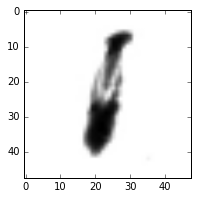

In [12]:
f = plt.figure(figsize=(16,3))
sub1 = plt.subplot(1,4,1)
plt.imshow(X[250][:,:,0], cmap='binary')

## Class imbalance
Since there is a strong class imbalance (lowest 7, highest 1580), something has to be done to counter this. Oversampling minority classes to be as big as the majority classes is the option used below. <br>
(Please do note that the validation split accuracy can not be seen as a surrogate for the test set.)

In [13]:
X = X.reshape(total,IMAGE_SIZE*IMAGE_SIZE)
print(X.shape)

sm = RandomOverSampler(ratio=class_counts)
X, Y_tmp = sm.fit_sample(X, Y_tmp)
print('Shapes:\nX:{}\nY:{}'.format(X.shape, Y_tmp.shape))

X = X.reshape(len(X),IMAGE_SIZE,IMAGE_SIZE,1)
for i in range(len(Y_tmp)):
    Y[i][int(Y_tmp[i])] = 1.0
del(Y_tmp)
print('Shapes:\nX:{}\nY:{}'.format(X.shape, Y.shape))

(24204, 2304)
Shapes:
X:(51985, 2304)
Y:(51985,)
Shapes:
X:(51985, 48, 48, 1)
Y:(51985, 121)


In [14]:
for i in range(total,X.shape[0]):
    # rotate RandomOverSampler images by one of 0/90/180/270 degrees
    X[i] = np.rot90(X[i],(1+(i%4)))

Uncomment the lines below appropriately if a validation split is to be used.

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
# only uncomment if train/validation variables are used
# del(X)
# del(Y)

## Threshold, dilation & labeling to extract largest non background area

In [88]:
def getLargestRegion(array):
    # Threshold image
    imthr = np.where(array < np.mean(array),0.,1.0)

    # Dilate image
    imdilated = morphology.dilation(imthr, np.ones((2,2)))
    
    # Label sections
    labels = measure.label(imdilated)
    labels = imthr*labels
    labels = labels.astype(int)

    # Get largest region
    regionmaxprop = None
    regions = measure.regionprops(labels)
    for regionprop in regions:
        # check to see if the region is at least 50% nonzero
        if regionmaxprop is None:
            regionmaxprop = regionprop
        if regionmaxprop.filled_area < regionprop.filled_area:
            regionmaxprop = regionprop
            
    return np.where(labels == regionmaxprop.label,1.0,0.0)

## Apply transformations to train set

In [103]:
for i in range(len(X)):
    X[i] = getLargestRegion(X[i][:,:,0]).reshape((IMAGE_SIZE,IMAGE_SIZE,1))

## Define and train CNN

In [ ]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=X[0].shape))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
__________

In [ ]:
history = model.fit(
    X, 
    Y,
    epochs=N_EPOCHS, 
    batch_size=BATCH_SIZE,
    verbose=1)

Epoch 1/15
16480/51985 [========>.....................] - ETA: 4814s - loss: 15.9298 - acc: 0.0103

In [ ]:
model.save('../data/output/models/model10_2x64_2x128_4x256.h5')

In [104]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=X[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
__________

In [105]:
history = model.fit(
    X, 
    Y,
    epochs=N_EPOCHS, 
    batch_size=BATCH_SIZE,
    verbose=1)

Epoch 1/15
51985/51985 [==============================] - 578s 11ms/step - loss: 3.4685 - acc: 0.1728
Epoch 2/15
51985/51985 [==============================] - 538s 10ms/step - loss: 2.7769 - acc: 0.2827
Epoch 3/15
51985/51985 [==============================] - 538s 10ms/step - loss: 2.6093 - acc: 0.3178
Epoch 4/15
51985/51985 [==============================] - 533s 10ms/step - loss: 2.5489 - acc: 0.3349
Epoch 5/15
51985/51985 [==============================] - 554s 11ms/step - loss: 2.5177 - acc: 0.3470
Epoch 6/15
51985/51985 [==============================] - 580s 11ms/step - loss: 2.4951 - acc: 0.3514
Epoch 7/15
51985/51985 [==============================] - 579s 11ms/step - loss: 2.4825 - acc: 0.3571
Epoch 8/15
51985/51985 [==============================] - 604s 12ms/step - loss: 2.4758 - acc: 0.3593
Epoch 9/15
51985/51985 [==============================] - 680s 13ms/step - loss: 2.4893 - acc: 0.3597
Epoch 10/15
51985/51985 [==============================] - 636s 12ms/step - loss: 

KeyboardInterrupt: 

In [106]:
model.save('../data/output/models/modellabeled.h5')

In [ ]:
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()